<a href="https://colab.research.google.com/github/ritwiks9635/My_Neural_Network_Architecture/blob/main/Masked_image_modeling_with_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Masked image modeling with Autoencoders**

## Introduction

In deep learning, models with growing **capacity** and **capability** can easily overfit
on large datasets (ImageNet-1K). In the field of natural language processing, the
appetite for data has been **successfully addressed** by self-supervised pretraining.

In the academic paper
[Masked Autoencoders Are Scalable Vision Learners](https://arxiv.org/abs/2111.06377)
by He et. al. the authors propose a simple yet effective method to pretrain large
vision models (here [ViT Huge](https://arxiv.org/abs/2010.11929)). Inspired from
the pretraining algorithm of BERT ([Devlin et al.](https://arxiv.org/abs/1810.04805)),
they mask patches of an image and, through an autoencoder predict the masked patches.
In the spirit of "masked language modeling", this pretraining task could be referred
to as "masked image modeling".

In this example, we implement
[Masked Autoencoders Are Scalable Vision Learners](https://arxiv.org/abs/2111.06377)
with the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset. After
pretraining a scaled down version of ViT, we also implement the linear evaluation
pipeline on CIFAR-10.


This implementation covers (MAE refers to Masked Autoencoder):

- The masking algorithm
- MAE encoder
- MAE decoder
- Evaluation with linear probing

As a reference, we reuse some of the code presented in
[this example](https://keras.io/examples/vision/image_classification_with_vision_transformer/).

In [1]:
pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 8.1 MB/s eta 0:00:00


In [2]:
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from tensorflow.keras import layers

SEED = 42
tf.random.set_seed(SEED)

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Hyperparameters for pretraining

Please feel free to change the hyperparameters and check your results. The best way to
get an intuition about the architecture is to experiment with it. Our hyperparameters are
heavily inspired by the design guidelines laid out by the authors in
[the original paper](https://arxiv.org/abs/2111.06377).

In [3]:
# DATA
BUFFER_SIZE = 1024
BATCH_SIZE = 256
AUTO = tf.data.AUTOTUNE
INPUT_SHAPE = (32, 32, 3)
NUM_CLASSES = 10

# OPTIMIZER
LEARNING_RATE = 5e-3
WEIGHT_DECAY = 1e-4

# PRETRAINING
EPOCHS = 100

# AUGMENTATION
IMAGE_SIZE = 48  # We will resize input images to this size.
PATCH_SIZE = 6  # Size of the patches to be extracted from the input images.
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2
MASK_PROPORTION = 0.75  # We have found 75% masking to give us the best results.

# ENCODER and DECODER
LAYER_NORM_EPS = 1e-6
ENC_PROJECTION_DIM = 128
DEC_PROJECTION_DIM = 64
ENC_NUM_HEADS = 4
ENC_LAYERS = 6
DEC_NUM_HEADS = 4
DEC_LAYERS = (
    2  # The decoder is lightweight but should be reasonably deep for reconstruction.
)
ENC_TRANSFORMER_UNITS = [
    ENC_PROJECTION_DIM * 2,
    ENC_PROJECTION_DIM,
]  # Size of the transformer layers.
DEC_TRANSFORMER_UNITS = [
    DEC_PROJECTION_DIM * 2,
    DEC_PROJECTION_DIM,
]

In [4]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

(x_train, y_train), (x_val, y_val) = (
            (x_train[:40000], y_train[:40000]),
            (x_train[40000:], y_train[40000:])
            )

print(f"Training samples: {len(x_train)}")
print(f"Validation samples: {len(x_val)}")
print(f"Testing samples: {len(x_test)}")

train_ds = tf.data.Dataset.from_tensor_slices(x_train)
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(AUTO)

val_ds = tf.data.Dataset.from_tensor_slices(x_val)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(AUTO)

test_ds = tf.data.Dataset.from_tensor_slices(x_test)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTO)

170498071/170498071 [==============================] - 4s 0us/step
Training samples: 40000
Validation samples: 10000
Testing samples: 10000


## Data augmentation

In previous self-supervised pretraining methodologies
([SimCLR](https://arxiv.org/abs/2002.05709) alike), we have noticed that the data
augmentation pipeline plays an important role. On the other hand the authors of this
paper point out that Masked Autoencoders **do not** rely on augmentations. They propose a
simple augmentation pipeline of:


- Resizing
- Random cropping (fixed-sized or random sized)
- Random horizontal flipping

In [5]:
def get_train_augmentation_model():
    model = keras.Sequential(
        [
            layers.Rescaling(1 / 255.0),
            layers.Resizing(INPUT_SHAPE[0] + 20, INPUT_SHAPE[0] + 20),
            layers.RandomCrop(IMAGE_SIZE, IMAGE_SIZE),
            layers.RandomFlip("horizontal"),
        ],
        name="train_data_augmentation",
    )
    return model


def get_test_augmentation_model():
    model = keras.Sequential(
        [layers.Rescaling(1 / 255.0), layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),],
        name="test_data_augmentation",
    )
    return model

## A layer for extracting patches from images

This layer takes images as input and divides them into patches. The layer also includes
two utility method:

- `show_patched_image` -- Takes a batch of images and its corresponding patches to plot a
random pair of image and patches.
- `reconstruct_from_patch` -- Takes a single instance of patches and stitches them
together into the original image.

In [6]:
class Patches(layers.Layer):
    def __init__(self, patch_size=PATCH_SIZE, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size

        # Assuming the image has three channels each patch would be
        # of size (patch_size, patch_size, 3).
        self.resize = layers.Reshape((-1, patch_size * patch_size * 3))

    def call(self, images):
        # Create patches from the input images
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )

        # Reshape the patches to (batch, num_patches, patch_area) and return it.
        patches = self.resize(patches)
        return patches

    def show_patched_image(self, images, patches):
        # This is a utility function which accepts a batch of images and its
        # corresponding patches and help visualize one image and its patches
        # side by side.
        idx = np.random.choice(patches.shape[0])
        print(f"Index selected: {idx}.")

        plt.figure(figsize=(4, 4))
        plt.imshow(keras.utils.array_to_img(images[idx]))
        plt.axis("off")
        plt.show()

        n = int(np.sqrt(patches.shape[1]))
        plt.figure(figsize=(4, 4))
        for i, patch in enumerate(patches[idx]):
            ax = plt.subplot(n, n, i + 1)
            patch_img = tf.reshape(patch, (self.patch_size, self.patch_size, 3))
            plt.imshow(keras.utils.img_to_array(patch_img))
            plt.axis("off")
        plt.show()

        # Return the index chosen to validate it outside the method.
        return idx

    # taken from https://stackoverflow.com/a/58082878/10319735
    def reconstruct_from_patch(self, patch):
        # This utility function takes patches from a *single* image and
        # reconstructs it back into the image. This is useful for the train
        # monitor callback.
        num_patches = patch.shape[0]
        n = int(np.sqrt(num_patches))
        patch = tf.reshape(patch, (num_patches, self.patch_size, self.patch_size, 3))
        rows = tf.split(patch, n, axis=0)
        rows = [tf.concat(tf.unstack(x), axis=1) for x in rows]
        reconstructed = tf.concat(rows, axis=0)
        return reconstructed

Index selected: 23.


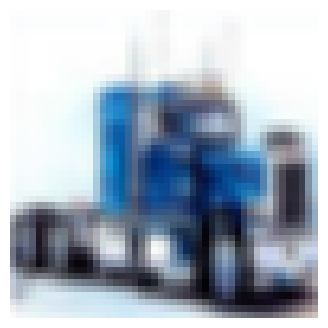

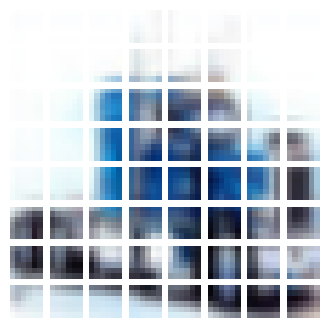

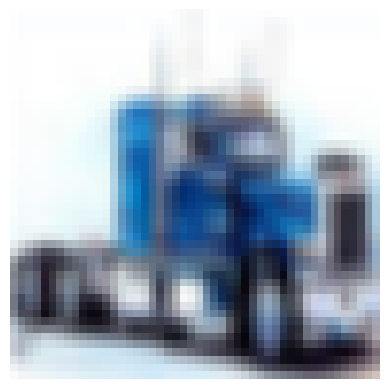

In [7]:
# Get a batch of images.
image_batch = next(iter(train_ds))

# Augment the images.
augmentation_model = get_train_augmentation_model()
augmented_images = augmentation_model(image_batch)

# Define the patch layer.
patch_layer = Patches()

# Get the patches from the batched images.
patches = patch_layer(images=augmented_images)

# Now pass the images and the corresponding patches
# to the `show_patched_image` method.
random_index = patch_layer.show_patched_image(images=augmented_images, patches=patches)

# Chose the same chose image and try reconstructing the patches
# into the original image.
image = patch_layer.reconstruct_from_patch(patches[random_index])
plt.imshow(image)
plt.axis("off")
plt.show()

## Patch encoding with masking

Quoting the paper

> Following ViT, we divide an image into regular non-overlapping patches. Then we sample
a subset of patches and mask (i.e., remove) the remaining ones. Our sampling strategy is
straightforward: we sample random patches without replacement, following a uniform
distribution. We simply refer to this as “random sampling”.

This layer includes masking and encoding the patches.

The utility methods of the layer are:

- `get_random_indices` -- Provides the mask and unmask indices.
- `generate_masked_image` -- Takes patches and unmask indices, results in a random masked
image. This is an essential utility method for our training monitor callback (defined
later).

In [8]:
class PatchEncoder(layers.Layer):
    def __init__(
        self,
        patch_size=PATCH_SIZE,
        projection_dim=ENC_PROJECTION_DIM,
        mask_proportion=MASK_PROPORTION,
        downstream=False,
        **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size
        self.projection_dim = projection_dim
        self.mask_proportion = mask_proportion
        self.downstream = downstream

        # This is a trainable mask token initialized randomly from a normal
        # distribution.
        self.mask_token = tf.Variable(
            tf.random.normal([1, patch_size * patch_size * 3]), trainable=True
        )

    def build(self, input_shape):
        (_, self.num_patches, self.patch_area) = input_shape

        # Create the projection layer for the patches.
        self.projection = layers.Dense(units=self.projection_dim)

        # Create the positional embedding layer.
        self.position_embedding = layers.Embedding(
            input_dim=self.num_patches, output_dim=self.projection_dim
        )

        # Number of patches that will be masked.
        self.num_mask = int(self.mask_proportion * self.num_patches)

    def call(self, patches):
        # Get the positional embeddings.
        batch_size = tf.shape(patches)[0]
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        pos_embeddings = self.position_embedding(positions[tf.newaxis, ...])
        pos_embeddings = tf.tile(
            pos_embeddings, [batch_size, 1, 1]
        )  # (B, num_patches, projection_dim)

        # Embed the patches.
        patch_embeddings = (
            self.projection(patches) + pos_embeddings
        )  # (B, num_patches, projection_dim)

        if self.downstream:
            return patch_embeddings
        else:
            mask_indices, unmask_indices = self.get_random_indices(batch_size)
            # The encoder input is the unmasked patch embeddings. Here we gather
            # all the patches that should be unmasked.
            unmasked_embeddings = tf.gather(
                patch_embeddings, unmask_indices, axis=1, batch_dims=1
            )  # (B, unmask_numbers, projection_dim)

            # Get the unmasked and masked position embeddings. We will need them
            # for the decoder.
            unmasked_positions = tf.gather(
                pos_embeddings, unmask_indices, axis=1, batch_dims=1
            )  # (B, unmask_numbers, projection_dim)
            masked_positions = tf.gather(
                pos_embeddings, mask_indices, axis=1, batch_dims=1
            )  # (B, mask_numbers, projection_dim)

            # Repeat the mask token number of mask times.
            # Mask tokens replace the masks of the image.
            mask_tokens = tf.repeat(self.mask_token, repeats=self.num_mask, axis=0)
            mask_tokens = tf.repeat(
                mask_tokens[tf.newaxis, ...], repeats=batch_size, axis=0
            )

            # Get the masked embeddings for the tokens.
            masked_embeddings = self.projection(mask_tokens) + masked_positions
            return (
                unmasked_embeddings,  # Input to the encoder.
                masked_embeddings,  # First part of input to the decoder.
                unmasked_positions,  # Added to the encoder outputs.
                mask_indices,  # The indices that were masked.
                unmask_indices,  # The indices that were unmaksed.
            )

    def get_random_indices(self, batch_size):
        # Create random indices from a uniform distribution and then split
        # it into mask and unmask indices.
        rand_indices = tf.argsort(
            tf.random.uniform(shape=(batch_size, self.num_patches)), axis=-1
        )
        mask_indices = rand_indices[:, : self.num_mask]
        unmask_indices = rand_indices[:, self.num_mask :]
        return mask_indices, unmask_indices

    def generate_masked_image(self, patches, unmask_indices):
        # Choose a random patch and it corresponding unmask index.
        idx = np.random.choice(patches.shape[0])
        patch = patches[idx]
        unmask_index = unmask_indices[idx]

        # Build a numpy array of same shape as patch.
        new_patch = np.zeros_like(patch)

        # Iterate of the new_patch and plug the unmasked patches.
        count = 0
        for i in range(unmask_index.shape[0]):
            new_patch[unmask_index[i]] = patch[unmask_index[i]]
        return new_patch, idx

Let's see the masking process in action on a sample image.

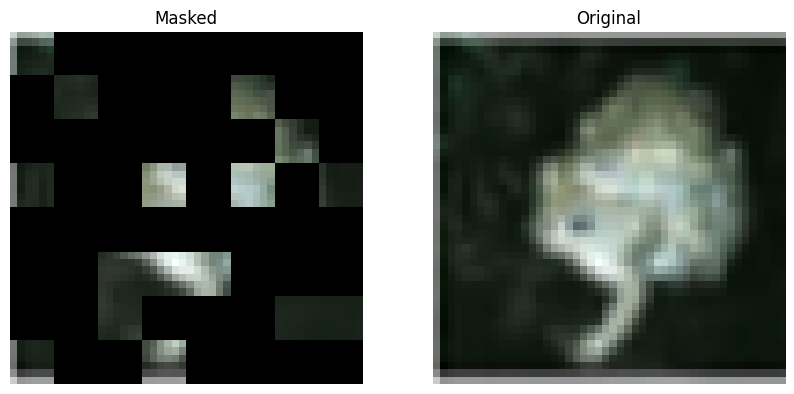

In [9]:
# Create the patch encoder layer.
patch_encoder = PatchEncoder()

# Get the embeddings and positions.
(
    unmasked_embeddings,
    masked_embeddings,
    unmasked_positions,
    mask_indices,
    unmask_indices,
) = patch_encoder(patches=patches)


# Show a maksed patch image.
new_patch, random_index = patch_encoder.generate_masked_image(patches, unmask_indices)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
img = patch_layer.reconstruct_from_patch(new_patch)
plt.imshow(keras.utils.array_to_img(img))
plt.axis("off")
plt.title("Masked")
plt.subplot(1, 2, 2)
img = augmented_images[random_index]
plt.imshow(keras.utils.array_to_img(img))
plt.axis("off")
plt.title("Original")
plt.show()

## MLP

This serves as the fully connected feed forward network of the transformer architecture.

In [10]:
def mlp(x, dropout_rate, hidden_units):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

## MAE encoder

The MAE encoder is ViT. The only point to note here is that the encoder outputs a layer
normalized output.

In [11]:
def create_encoder(num_heads=ENC_NUM_HEADS, num_layers=ENC_LAYERS):
    inputs = layers.Input((None, ENC_PROJECTION_DIM))
    x = inputs

    for _ in range(num_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)

        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=ENC_PROJECTION_DIM, dropout=0.1
        )(x1, x1)

        # Skip connection 1.
        x2 = layers.Add()([attention_output, x])

        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x2)

        # MLP.
        x3 = mlp(x3, hidden_units=ENC_TRANSFORMER_UNITS, dropout_rate=0.1)

        # Skip connection 2.
        x = layers.Add()([x3, x2])

    outputs = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)
    return keras.Model(inputs, outputs, name="mae_encoder")

## MAE decoder

The authors point out that they use an **asymmetric** autoencoder model. They use a
lightweight decoder that takes "<10% computation per token vs. the encoder". We are not
specific with the "<10% computation" in our implementation but have used a smaller
decoder (both in terms of depth and projection dimensions).

In [12]:
def create_decoder(
    num_layers=DEC_LAYERS, num_heads=DEC_NUM_HEADS, image_size=IMAGE_SIZE):
    inputs = layers.Input((NUM_PATCHES, ENC_PROJECTION_DIM))
    x = layers.Dense(DEC_PROJECTION_DIM)(inputs)

    for _ in range(num_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)

        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=DEC_PROJECTION_DIM, dropout=0.1
        )(x1, x1)

        # Skip connection 1.
        x2 = layers.Add()([attention_output, x])

        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x2)

        # MLP.
        x3 = mlp(x3, hidden_units=DEC_TRANSFORMER_UNITS, dropout_rate=0.1)

        # Skip connection 2.
        x = layers.Add()([x3, x2])

    x = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)
    x = layers.Flatten()(x)
    pre_final = layers.Dense(units=image_size * image_size * 3, activation="sigmoid")(x)
    outputs = layers.Reshape((image_size, image_size, 3))(pre_final)

    return keras.Model(inputs, outputs, name="mae_decoder")

## MAE trainer

This is the trainer module. We wrap the encoder and decoder inside of a `tf.keras.Model`
subclass. This allows us to customize what happens in the `model.fit()` loop.

In [13]:
class MaskedAutoencoder(keras.Model):
    def __init__(
        self,
        train_augmentation_model,
        test_augmentation_model,
        patch_layer,
        patch_encoder,
        encoder,
        decoder,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.train_augmentation_model = train_augmentation_model
        self.test_augmentation_model = test_augmentation_model
        self.patch_layer = patch_layer
        self.patch_encoder = patch_encoder
        self.encoder = encoder
        self.decoder = decoder

    def calculate_loss(self, images, test=False):
        # Augment the input images.
        if test:
            augmented_images = self.test_augmentation_model(images)
        else:
            augmented_images = self.train_augmentation_model(images)

        # Patch the augmented images.
        patches = self.patch_layer(augmented_images)

        # Encode the patches.
        (
            unmasked_embeddings,
            masked_embeddings,
            unmasked_positions,
            mask_indices,
            unmask_indices,
        ) = self.patch_encoder(patches)

        # Pass the unmaksed patche to the encoder.
        encoder_outputs = self.encoder(unmasked_embeddings)

        # Create the decoder inputs.
        encoder_outputs = encoder_outputs + unmasked_positions
        decoder_inputs = tf.concat([encoder_outputs, masked_embeddings], axis=1)

        # Decode the inputs.
        decoder_outputs = self.decoder(decoder_inputs)
        decoder_patches = self.patch_layer(decoder_outputs)

        loss_patch = tf.gather(patches, mask_indices, axis=1, batch_dims=1)
        loss_output = tf.gather(decoder_patches, mask_indices, axis=1, batch_dims=1)

        # Compute the total loss.
        total_loss = self.compiled_loss(loss_patch, loss_output)

        return total_loss, loss_patch, loss_output

    def train_step(self, images):
        with tf.GradientTape() as tape:
            total_loss, loss_patch, loss_output = self.calculate_loss(images)

        # Apply gradients.
        train_vars = [
            self.train_augmentation_model.trainable_variables,
            self.patch_layer.trainable_variables,
            self.patch_encoder.trainable_variables,
            self.encoder.trainable_variables,
            self.decoder.trainable_variables,
        ]
        grads = tape.gradient(total_loss, train_vars)
        tv_list = []
        for (grad, var) in zip(grads, train_vars):
            for g, v in zip(grad, var):
                tv_list.append((g, v))
        self.optimizer.apply_gradients(tv_list)

        # Report progress.
        self.compiled_metrics.update_state(loss_patch, loss_output)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, images):
        total_loss, loss_patch, loss_output = self.calculate_loss(images, test=True)

        # Update the trackers.
        self.compiled_metrics.update_state(loss_patch, loss_output)
        return {m.name: m.result() for m in self.metrics}

In [14]:
train_augmentation_model = get_train_augmentation_model()
test_augmentation_model = get_test_augmentation_model()
patch_layer = Patches()
patch_encoder = PatchEncoder()
encoder = create_encoder()
decoder = create_decoder()

mae_model = MaskedAutoencoder(
    train_augmentation_model=train_augmentation_model,
    test_augmentation_model=test_augmentation_model,
    patch_layer=patch_layer,
    patch_encoder=patch_encoder,
    encoder=encoder,
    decoder=decoder,
)

## Training callbacks



### Visualization callback

In [15]:
# Taking a batch of test inputs to measure model's progress.
test_images = next(iter(test_ds))


class TrainMonitor(keras.callbacks.Callback):
    def __init__(self, epoch_interval=None):
        self.epoch_interval = epoch_interval

    def on_epoch_end(self, epoch, logs=None):
        if self.epoch_interval and epoch % self.epoch_interval == 0:
            test_augmented_images = self.model.test_augmentation_model(test_images)
            test_patches = self.model.patch_layer(test_augmented_images)
            (
                test_unmasked_embeddings,
                test_masked_embeddings,
                test_unmasked_positions,
                test_mask_indices,
                test_unmask_indices,
            ) = self.model.patch_encoder(test_patches)
            test_encoder_outputs = self.model.encoder(test_unmasked_embeddings)
            test_encoder_outputs = test_encoder_outputs + test_unmasked_positions
            test_decoder_inputs = tf.concat(
                [test_encoder_outputs, test_masked_embeddings], axis=1
            )
            test_decoder_outputs = self.model.decoder(test_decoder_inputs)

            # Show a maksed patch image.
            test_masked_patch, idx = self.model.patch_encoder.generate_masked_image(
                test_patches, test_unmask_indices
            )
            print(f"\nIdx chosen: {idx}")
            original_image = test_augmented_images[idx]
            masked_image = self.model.patch_layer.reconstruct_from_patch(
                test_masked_patch
            )
            reconstructed_image = test_decoder_outputs[idx]

            fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
            ax[0].imshow(original_image)
            ax[0].set_title(f"Original: {epoch:03d}")

            ax[1].imshow(masked_image)
            ax[1].set_title(f"Masked: {epoch:03d}")

            ax[2].imshow(reconstructed_image)
            ax[2].set_title(f"Resonstructed: {epoch:03d}")

            plt.show()
            plt.close()

### Learning rate scheduler

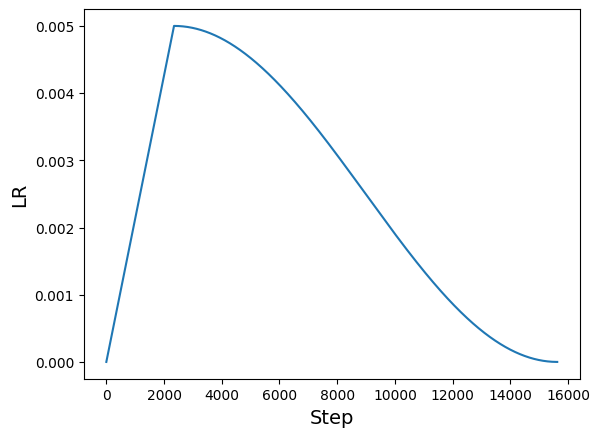

In [16]:
# Some code is taken from:
# https://www.kaggle.com/ashusma/training-rfcx-tensorflow-tpu-effnet-b2.


class WarmUpCosine(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super().__init__()

        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")

        cos_annealed_lr = tf.cos(
            self.pi
            * (tf.cast(step, tf.float32) - self.warmup_steps)
            / float(self.total_steps - self.warmup_steps)
        )
        learning_rate = 0.5 * self.learning_rate_base * (1 + cos_annealed_lr)

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )


total_steps = int((len(x_train) / BATCH_SIZE) * EPOCHS)
warmup_epoch_percentage = 0.15
warmup_steps = int(total_steps * warmup_epoch_percentage)
scheduled_lrs = WarmUpCosine(
    learning_rate_base=LEARNING_RATE,
    total_steps=total_steps,
    warmup_learning_rate=0.0,
    warmup_steps=warmup_steps,
)

lrs = [scheduled_lrs(step) for step in range(total_steps)]
plt.plot(lrs)
plt.xlabel("Step", fontsize=14)
plt.ylabel("LR", fontsize=14)
plt.show()

# Assemble the callbacks.
train_callbacks = [TrainMonitor(epoch_interval=5)]

Epoch 1/100
157/157 [==============================] - ETA: 0s - loss: 0.0508 - mae: 0.1812
Idx chosen: 176


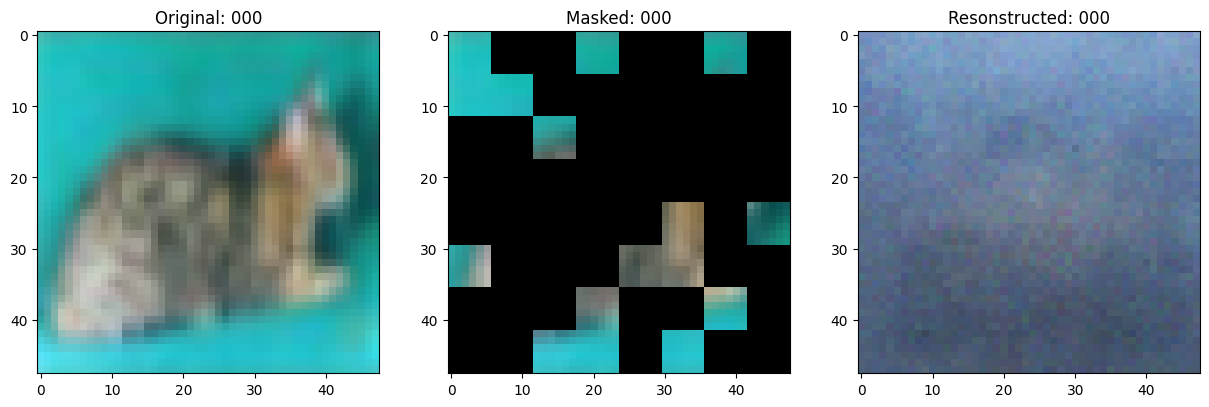

157/157 [==============================] - 34s 136ms/step - loss: 0.0508 - mae: 0.1812 - val_loss: 0.0423 - val_mae: 0.1650
Epoch 2/100
157/157 [==============================] - 22s 138ms/step - loss: 0.0388 - mae: 0.1556 - val_loss: 0.0355 - val_mae: 0.1474
Epoch 3/100
157/157 [==============================] - 20s 126ms/step - loss: 0.0335 - mae: 0.1416 - val_loss: 0.0325 - val_mae: 0.1403
Epoch 4/100
157/157 [==============================] - 21s 133ms/step - loss: 0.0307 - mae: 0.1344 - val_loss: 0.0298 - val_mae: 0.1317
Epoch 5/100
157/157 [==============================] - 21s 134ms/step - loss: 0.0280 - mae: 0.1271 - val_loss: 0.0293 - val_mae: 0.1289
Epoch 6/100
157/157 [==============================] - ETA: 0s - loss: 0.0254 - mae: 0.1203
Idx chosen: 159


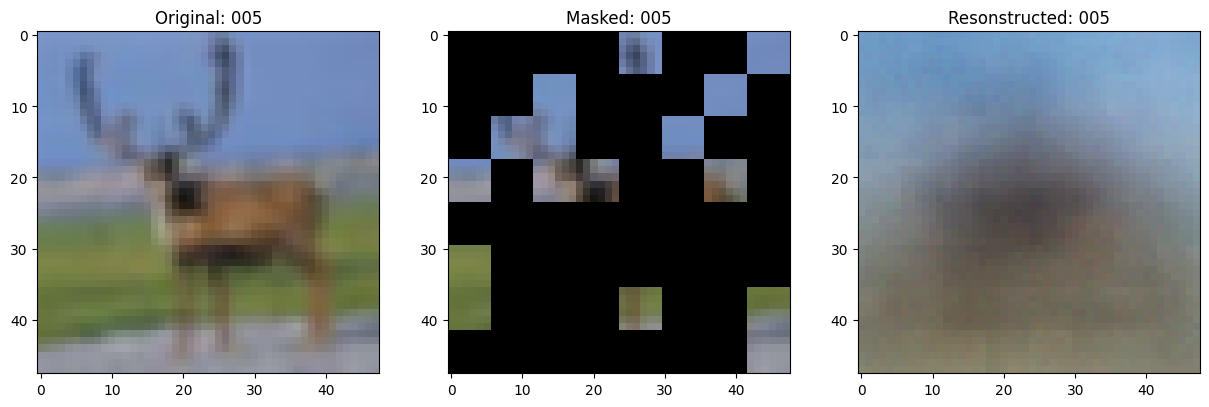

157/157 [==============================] - 21s 134ms/step - loss: 0.0254 - mae: 0.1203 - val_loss: 0.0243 - val_mae: 0.1161
Epoch 7/100
157/157 [==============================] - 20s 127ms/step - loss: 0.0236 - mae: 0.1153 - val_loss: 0.0226 - val_mae: 0.1117
Epoch 8/100
157/157 [==============================] - 21s 132ms/step - loss: 0.0223 - mae: 0.1115 - val_loss: 0.0218 - val_mae: 0.1111
Epoch 9/100
157/157 [==============================] - 20s 130ms/step - loss: 0.0214 - mae: 0.1087 - val_loss: 0.0209 - val_mae: 0.1073
Epoch 10/100
157/157 [==============================] - 20s 130ms/step - loss: 0.0207 - mae: 0.1065 - val_loss: 0.0208 - val_mae: 0.1069
Epoch 11/100
157/157 [==============================] - ETA: 0s - loss: 0.0204 - mae: 0.1055
Idx chosen: 19


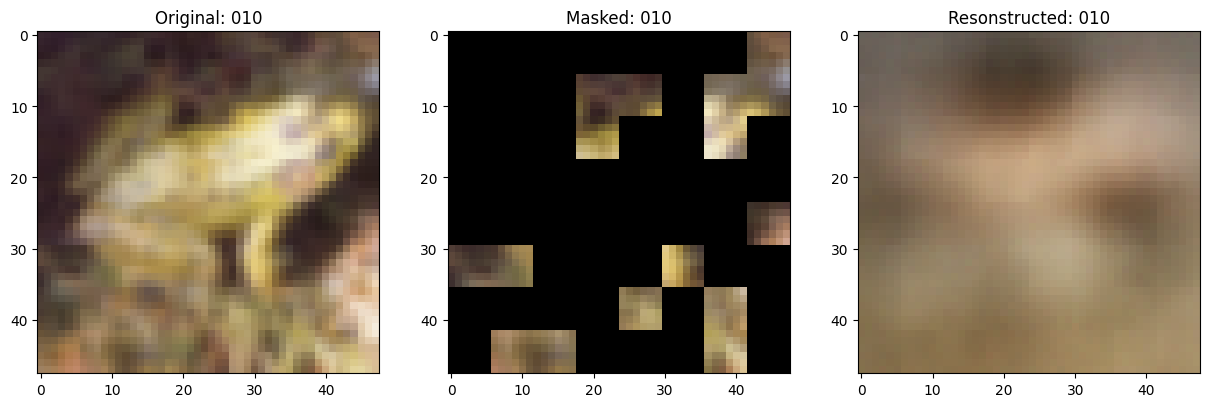

157/157 [==============================] - 22s 143ms/step - loss: 0.0204 - mae: 0.1055 - val_loss: 0.0201 - val_mae: 0.1034
Epoch 12/100
157/157 [==============================] - 22s 139ms/step - loss: 0.0198 - mae: 0.1038 - val_loss: 0.0203 - val_mae: 0.1038
Epoch 13/100
157/157 [==============================] - 21s 134ms/step - loss: 0.0196 - mae: 0.1030 - val_loss: 0.0193 - val_mae: 0.1007
Epoch 14/100
157/157 [==============================] - 20s 128ms/step - loss: 0.0194 - mae: 0.1022 - val_loss: 0.0191 - val_mae: 0.1001
Epoch 15/100
157/157 [==============================] - 20s 129ms/step - loss: 0.0191 - mae: 0.1012 - val_loss: 0.0195 - val_mae: 0.1010
Epoch 16/100
157/157 [==============================] - ETA: 0s - loss: 0.0190 - mae: 0.1008
Idx chosen: 121


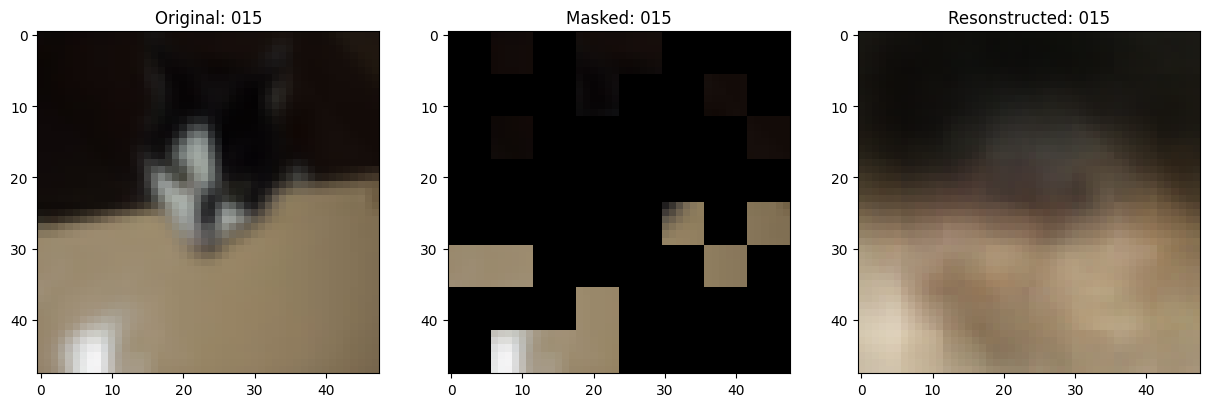

157/157 [==============================] - 24s 154ms/step - loss: 0.0190 - mae: 0.1008 - val_loss: 0.0189 - val_mae: 0.1005
Epoch 17/100
157/157 [==============================] - 20s 129ms/step - loss: 0.0186 - mae: 0.0995 - val_loss: 0.0185 - val_mae: 0.0989
Epoch 18/100
157/157 [==============================] - 21s 135ms/step - loss: 0.0185 - mae: 0.0992 - val_loss: 0.0190 - val_mae: 0.1009
Epoch 19/100
157/157 [==============================] - 20s 128ms/step - loss: 0.0183 - mae: 0.0986 - val_loss: 0.0183 - val_mae: 0.0980
Epoch 20/100
157/157 [==============================] - 20s 129ms/step - loss: 0.0182 - mae: 0.0982 - val_loss: 0.0180 - val_mae: 0.0977
Epoch 21/100
157/157 [==============================] - ETA: 0s - loss: 0.0180 - mae: 0.0975
Idx chosen: 2


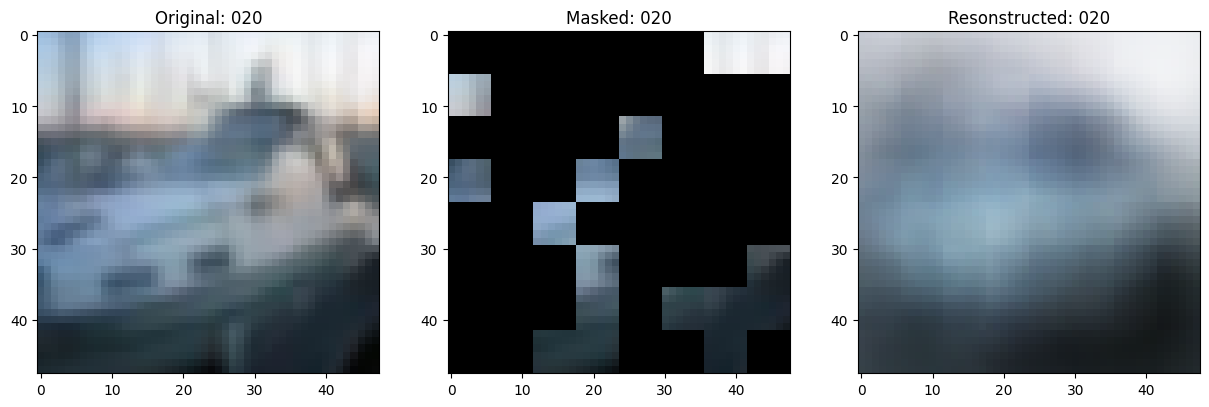

157/157 [==============================] - 22s 140ms/step - loss: 0.0180 - mae: 0.0975 - val_loss: 0.0181 - val_mae: 0.0969
Epoch 22/100
157/157 [==============================] - 20s 130ms/step - loss: 0.0179 - mae: 0.0972 - val_loss: 0.0185 - val_mae: 0.0986
Epoch 23/100
157/157 [==============================] - 20s 129ms/step - loss: 0.0179 - mae: 0.0970 - val_loss: 0.0181 - val_mae: 0.0980
Epoch 24/100
157/157 [==============================] - 20s 129ms/step - loss: 0.0179 - mae: 0.0969 - val_loss: 0.0181 - val_mae: 0.0972
Epoch 25/100
157/157 [==============================] - 21s 134ms/step - loss: 0.0176 - mae: 0.0962 - val_loss: 0.0178 - val_mae: 0.0968
Epoch 26/100
157/157 [==============================] - ETA: 0s - loss: 0.0176 - mae: 0.0960
Idx chosen: 27


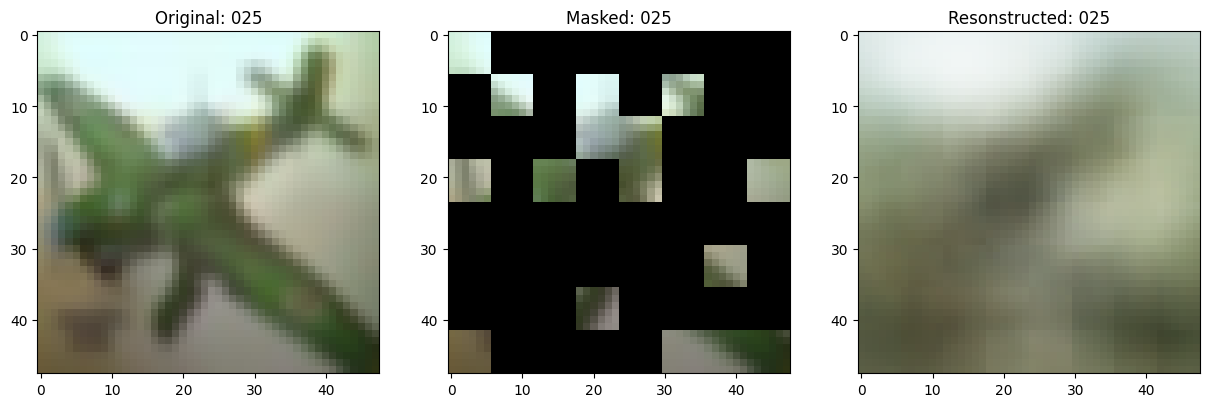

157/157 [==============================] - 21s 131ms/step - loss: 0.0176 - mae: 0.0960 - val_loss: 0.0174 - val_mae: 0.0947
Epoch 27/100
157/157 [==============================] - 20s 129ms/step - loss: 0.0174 - mae: 0.0955 - val_loss: 0.0176 - val_mae: 0.0958
Epoch 28/100
157/157 [==============================] - 20s 130ms/step - loss: 0.0175 - mae: 0.0957 - val_loss: 0.0178 - val_mae: 0.0964
Epoch 29/100
157/157 [==============================] - 20s 130ms/step - loss: 0.0174 - mae: 0.0953 - val_loss: 0.0176 - val_mae: 0.0957
Epoch 30/100
157/157 [==============================] - 20s 128ms/step - loss: 0.0173 - mae: 0.0950 - val_loss: 0.0176 - val_mae: 0.0951
Epoch 31/100
157/157 [==============================] - ETA: 0s - loss: 0.0173 - mae: 0.0949
Idx chosen: 13


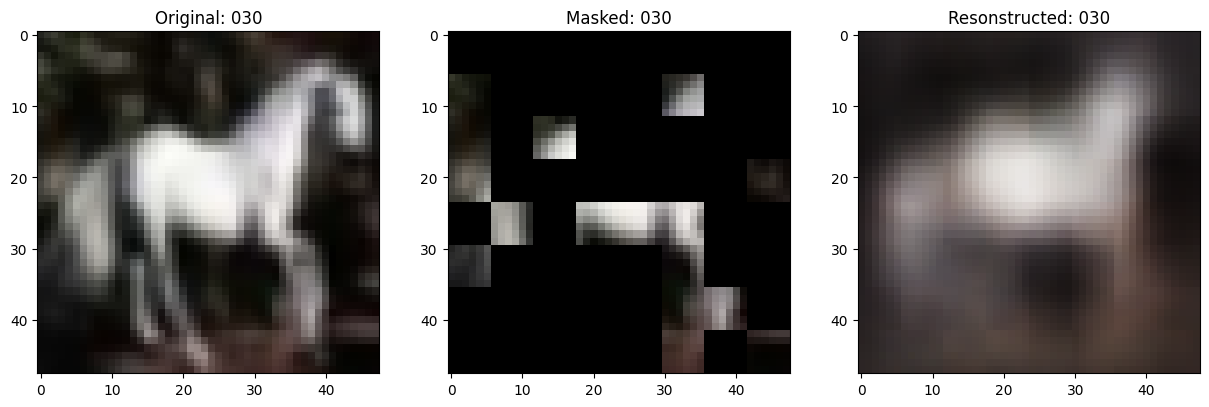

157/157 [==============================] - 21s 131ms/step - loss: 0.0173 - mae: 0.0949 - val_loss: 0.0172 - val_mae: 0.0945
Epoch 32/100
157/157 [==============================] - 20s 130ms/step - loss: 0.0172 - mae: 0.0945 - val_loss: 0.0178 - val_mae: 0.0978
Epoch 33/100
157/157 [==============================] - 20s 129ms/step - loss: 0.0172 - mae: 0.0946 - val_loss: 0.0171 - val_mae: 0.0938
Epoch 34/100
157/157 [==============================] - 21s 134ms/step - loss: 0.0171 - mae: 0.0942 - val_loss: 0.0171 - val_mae: 0.0938
Epoch 35/100
157/157 [==============================] - 20s 129ms/step - loss: 0.0170 - mae: 0.0941 - val_loss: 0.0172 - val_mae: 0.0947
Epoch 36/100
157/157 [==============================] - ETA: 0s - loss: 0.0170 - mae: 0.0938
Idx chosen: 73


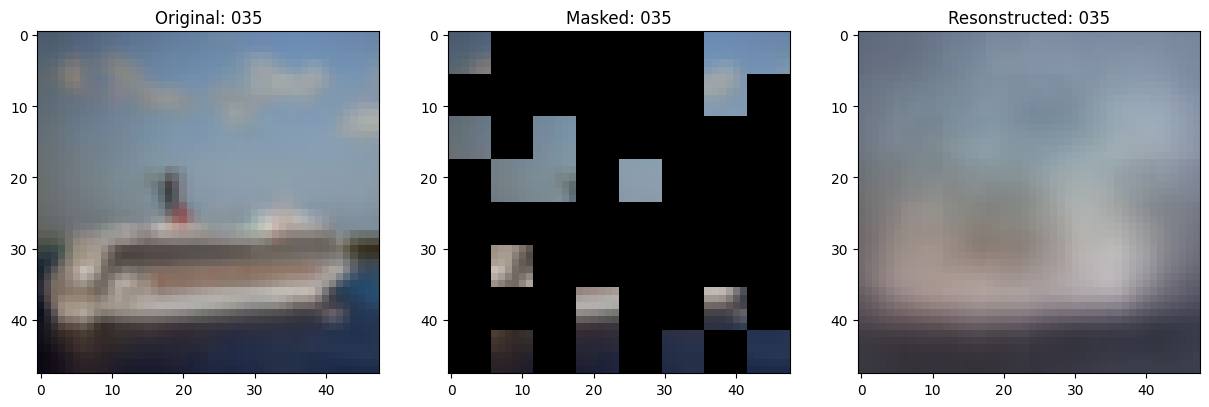

157/157 [==============================] - 22s 139ms/step - loss: 0.0170 - mae: 0.0938 - val_loss: 0.0176 - val_mae: 0.0959
Epoch 37/100
157/157 [==============================] - 20s 128ms/step - loss: 0.0170 - mae: 0.0937 - val_loss: 0.0171 - val_mae: 0.0935
Epoch 38/100
157/157 [==============================] - 20s 129ms/step - loss: 0.0169 - mae: 0.0935 - val_loss: 0.0170 - val_mae: 0.0942
Epoch 39/100
157/157 [==============================] - 20s 130ms/step - loss: 0.0168 - mae: 0.0933 - val_loss: 0.0169 - val_mae: 0.0936
Epoch 40/100
157/157 [==============================] - 20s 127ms/step - loss: 0.0167 - mae: 0.0930 - val_loss: 0.0169 - val_mae: 0.0933
Epoch 41/100
157/157 [==============================] - ETA: 0s - loss: 0.0167 - mae: 0.0930
Idx chosen: 226


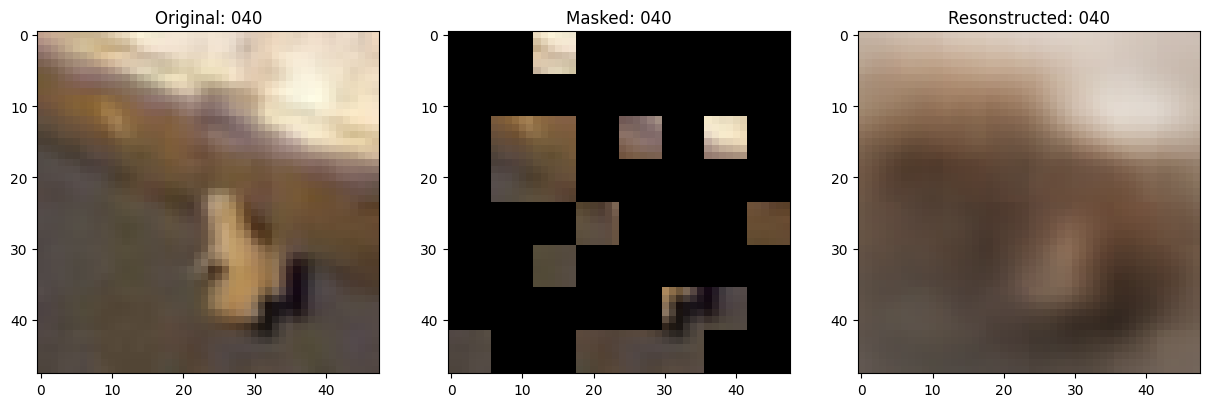

157/157 [==============================] - 21s 133ms/step - loss: 0.0167 - mae: 0.0930 - val_loss: 0.0167 - val_mae: 0.0927
Epoch 42/100
157/157 [==============================] - 21s 135ms/step - loss: 0.0166 - mae: 0.0926 - val_loss: 0.0170 - val_mae: 0.0941
Epoch 43/100
157/157 [==============================] - 20s 128ms/step - loss: 0.0166 - mae: 0.0926 - val_loss: 0.0166 - val_mae: 0.0919
Epoch 44/100
157/157 [==============================] - 20s 130ms/step - loss: 0.0165 - mae: 0.0921 - val_loss: 0.0165 - val_mae: 0.0923
Epoch 45/100
157/157 [==============================] - 21s 135ms/step - loss: 0.0165 - mae: 0.0920 - val_loss: 0.0165 - val_mae: 0.0915
Epoch 46/100
157/157 [==============================] - ETA: 0s - loss: 0.0165 - mae: 0.0920
Idx chosen: 248


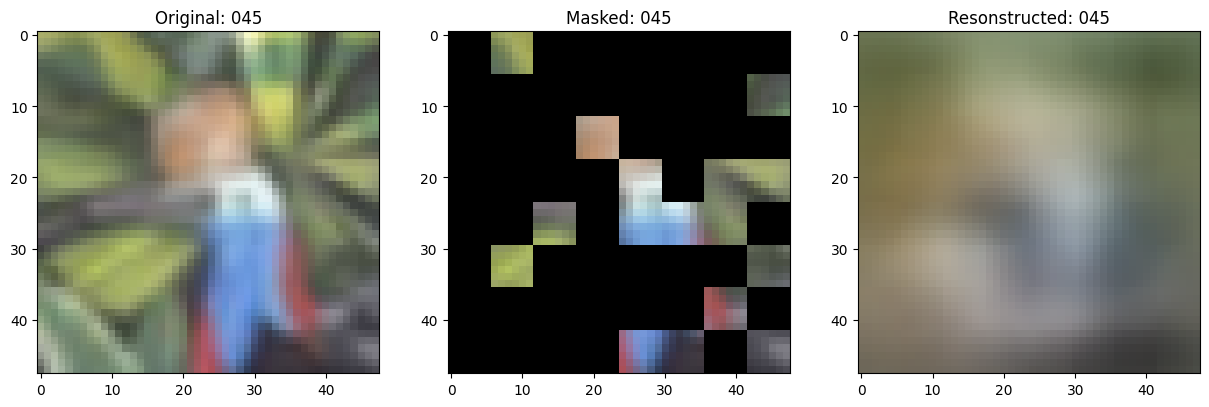

157/157 [==============================] - 21s 132ms/step - loss: 0.0165 - mae: 0.0920 - val_loss: 0.0167 - val_mae: 0.0921
Epoch 47/100
157/157 [==============================] - 21s 135ms/step - loss: 0.0164 - mae: 0.0918 - val_loss: 0.0166 - val_mae: 0.0915
Epoch 48/100
157/157 [==============================] - 21s 133ms/step - loss: 0.0163 - mae: 0.0915 - val_loss: 0.0166 - val_mae: 0.0912
Epoch 49/100
157/157 [==============================] - 20s 131ms/step - loss: 0.0163 - mae: 0.0915 - val_loss: 0.0167 - val_mae: 0.0930
Epoch 50/100
157/157 [==============================] - 20s 129ms/step - loss: 0.0163 - mae: 0.0915 - val_loss: 0.0165 - val_mae: 0.0920
Epoch 51/100
157/157 [==============================] - ETA: 0s - loss: 0.0163 - mae: 0.0914
Idx chosen: 138


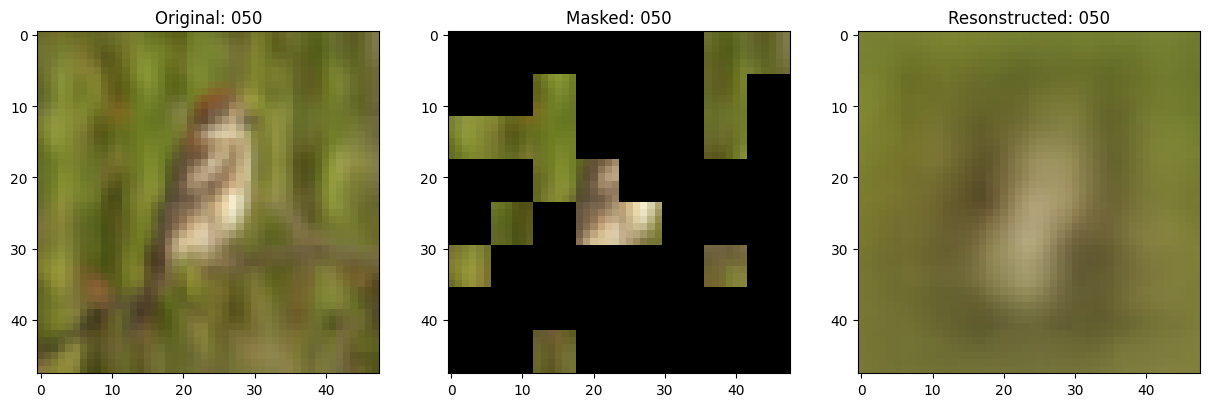

157/157 [==============================] - 21s 135ms/step - loss: 0.0163 - mae: 0.0914 - val_loss: 0.0164 - val_mae: 0.0917
Epoch 52/100
157/157 [==============================] - 20s 130ms/step - loss: 0.0162 - mae: 0.0911 - val_loss: 0.0164 - val_mae: 0.0916
Epoch 53/100
157/157 [==============================] - 21s 131ms/step - loss: 0.0161 - mae: 0.0908 - val_loss: 0.0161 - val_mae: 0.0904
Epoch 54/100
157/157 [==============================] - 20s 128ms/step - loss: 0.0161 - mae: 0.0907 - val_loss: 0.0162 - val_mae: 0.0900
Epoch 55/100
157/157 [==============================] - 20s 128ms/step - loss: 0.0160 - mae: 0.0904 - val_loss: 0.0164 - val_mae: 0.0917
Epoch 56/100
157/157 [==============================] - ETA: 0s - loss: 0.0160 - mae: 0.0903
Idx chosen: 103


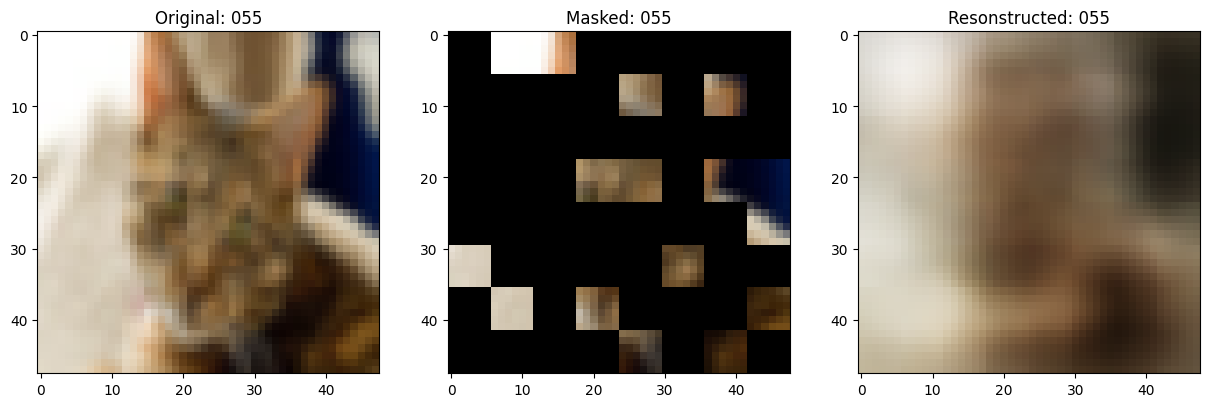

157/157 [==============================] - 21s 133ms/step - loss: 0.0160 - mae: 0.0903 - val_loss: 0.0161 - val_mae: 0.0907
Epoch 57/100
157/157 [==============================] - 20s 130ms/step - loss: 0.0159 - mae: 0.0900 - val_loss: 0.0160 - val_mae: 0.0893
Epoch 58/100
157/157 [==============================] - 21s 131ms/step - loss: 0.0159 - mae: 0.0900 - val_loss: 0.0163 - val_mae: 0.0912
Epoch 59/100
157/157 [==============================] - 20s 130ms/step - loss: 0.0159 - mae: 0.0899 - val_loss: 0.0162 - val_mae: 0.0905
Epoch 60/100
157/157 [==============================] - 20s 130ms/step - loss: 0.0158 - mae: 0.0896 - val_loss: 0.0158 - val_mae: 0.0886
Epoch 61/100
157/157 [==============================] - ETA: 0s - loss: 0.0158 - mae: 0.0894
Idx chosen: 29


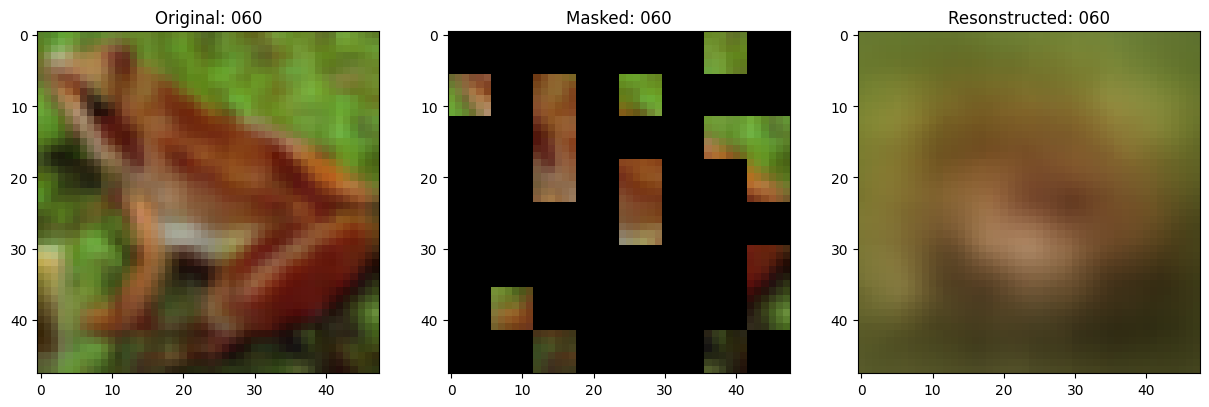

157/157 [==============================] - 22s 139ms/step - loss: 0.0158 - mae: 0.0894 - val_loss: 0.0158 - val_mae: 0.0889
Epoch 62/100
157/157 [==============================] - 21s 131ms/step - loss: 0.0158 - mae: 0.0893 - val_loss: 0.0161 - val_mae: 0.0894
Epoch 63/100
157/157 [==============================] - 21s 132ms/step - loss: 0.0157 - mae: 0.0892 - val_loss: 0.0158 - val_mae: 0.0891
Epoch 64/100
157/157 [==============================] - 20s 130ms/step - loss: 0.0157 - mae: 0.0891 - val_loss: 0.0158 - val_mae: 0.0890
Epoch 65/100
157/157 [==============================] - 20s 130ms/step - loss: 0.0157 - mae: 0.0889 - val_loss: 0.0158 - val_mae: 0.0889
Epoch 66/100
157/157 [==============================] - ETA: 0s - loss: 0.0157 - mae: 0.0890
Idx chosen: 87


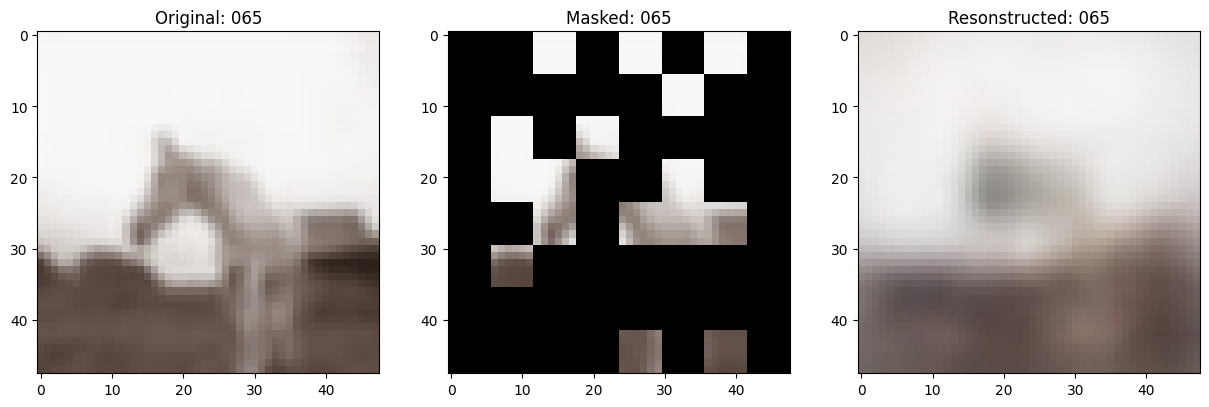

157/157 [==============================] - 22s 140ms/step - loss: 0.0157 - mae: 0.0890 - val_loss: 0.0159 - val_mae: 0.0899
Epoch 67/100
157/157 [==============================] - 21s 131ms/step - loss: 0.0156 - mae: 0.0886 - val_loss: 0.0157 - val_mae: 0.0882
Epoch 68/100
157/157 [==============================] - 21s 133ms/step - loss: 0.0156 - mae: 0.0886 - val_loss: 0.0157 - val_mae: 0.0884
Epoch 69/100
157/157 [==============================] - 20s 130ms/step - loss: 0.0155 - mae: 0.0882 - val_loss: 0.0157 - val_mae: 0.0880
Epoch 70/100
157/157 [==============================] - 20s 131ms/step - loss: 0.0155 - mae: 0.0882 - val_loss: 0.0158 - val_mae: 0.0888
Epoch 71/100
157/157 [==============================] - ETA: 0s - loss: 0.0155 - mae: 0.0881
Idx chosen: 17


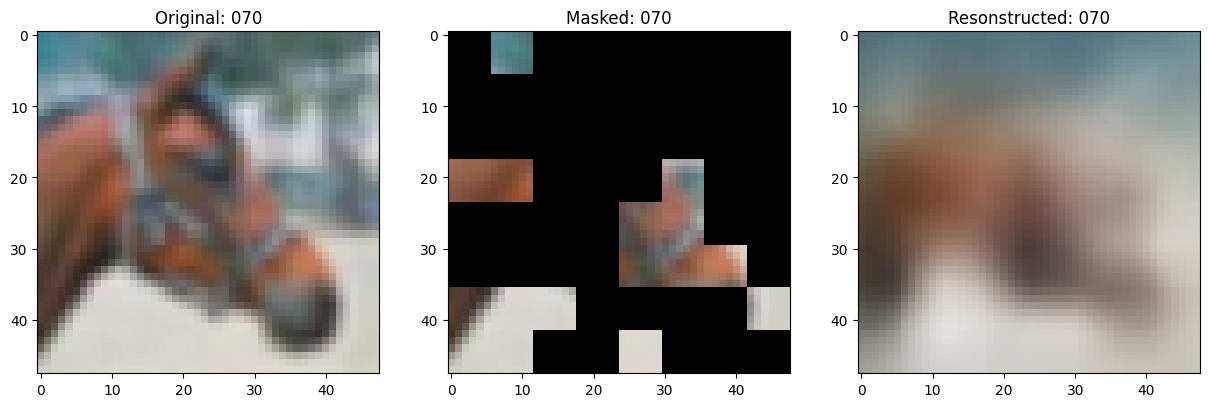

157/157 [==============================] - 22s 141ms/step - loss: 0.0155 - mae: 0.0881 - val_loss: 0.0155 - val_mae: 0.0876
Epoch 72/100
157/157 [==============================] - 21s 133ms/step - loss: 0.0154 - mae: 0.0878 - val_loss: 0.0155 - val_mae: 0.0873
Epoch 73/100
157/157 [==============================] - 22s 137ms/step - loss: 0.0154 - mae: 0.0878 - val_loss: 0.0155 - val_mae: 0.0878
Epoch 74/100
157/157 [==============================] - 20s 129ms/step - loss: 0.0153 - mae: 0.0875 - val_loss: 0.0154 - val_mae: 0.0878
Epoch 75/100
157/157 [==============================] - 21s 131ms/step - loss: 0.0152 - mae: 0.0874 - val_loss: 0.0154 - val_mae: 0.0882
Epoch 76/100
157/157 [==============================] - ETA: 0s - loss: 0.0152 - mae: 0.0872
Idx chosen: 207


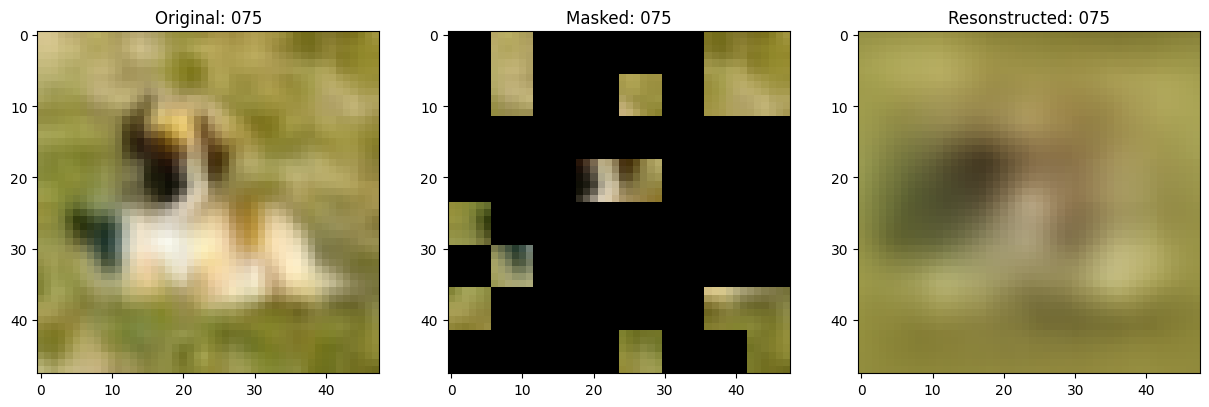

157/157 [==============================] - 21s 135ms/step - loss: 0.0152 - mae: 0.0872 - val_loss: 0.0152 - val_mae: 0.0867
Epoch 77/100
157/157 [==============================] - 21s 131ms/step - loss: 0.0152 - mae: 0.0872 - val_loss: 0.0154 - val_mae: 0.0882
Epoch 78/100
157/157 [==============================] - 21s 133ms/step - loss: 0.0152 - mae: 0.0872 - val_loss: 0.0152 - val_mae: 0.0865
Epoch 79/100
157/157 [==============================] - 21s 130ms/step - loss: 0.0152 - mae: 0.0869 - val_loss: 0.0153 - val_mae: 0.0869
Epoch 80/100
157/157 [==============================] - 21s 133ms/step - loss: 0.0151 - mae: 0.0869 - val_loss: 0.0152 - val_mae: 0.0868
Epoch 81/100
157/157 [==============================] - ETA: 0s - loss: 0.0151 - mae: 0.0867
Idx chosen: 145


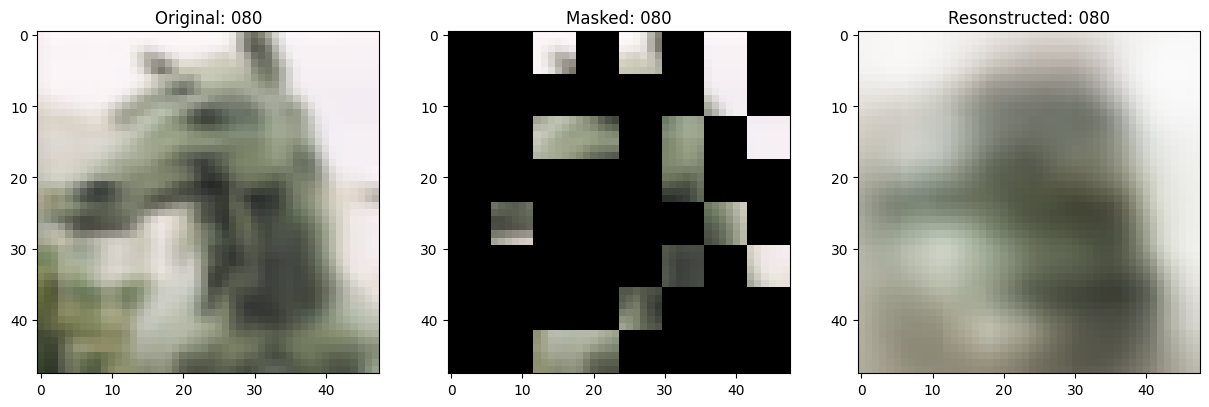

157/157 [==============================] - 21s 135ms/step - loss: 0.0151 - mae: 0.0867 - val_loss: 0.0152 - val_mae: 0.0865
Epoch 82/100
157/157 [==============================] - 21s 131ms/step - loss: 0.0151 - mae: 0.0865 - val_loss: 0.0152 - val_mae: 0.0864
Epoch 83/100
157/157 [==============================] - 20s 130ms/step - loss: 0.0150 - mae: 0.0864 - val_loss: 0.0151 - val_mae: 0.0862
Epoch 84/100
157/157 [==============================] - 20s 130ms/step - loss: 0.0150 - mae: 0.0862 - val_loss: 0.0151 - val_mae: 0.0860
Epoch 85/100
157/157 [==============================] - 20s 129ms/step - loss: 0.0149 - mae: 0.0861 - val_loss: 0.0151 - val_mae: 0.0863
Epoch 86/100
157/157 [==============================] - ETA: 0s - loss: 0.0149 - mae: 0.0861
Idx chosen: 145


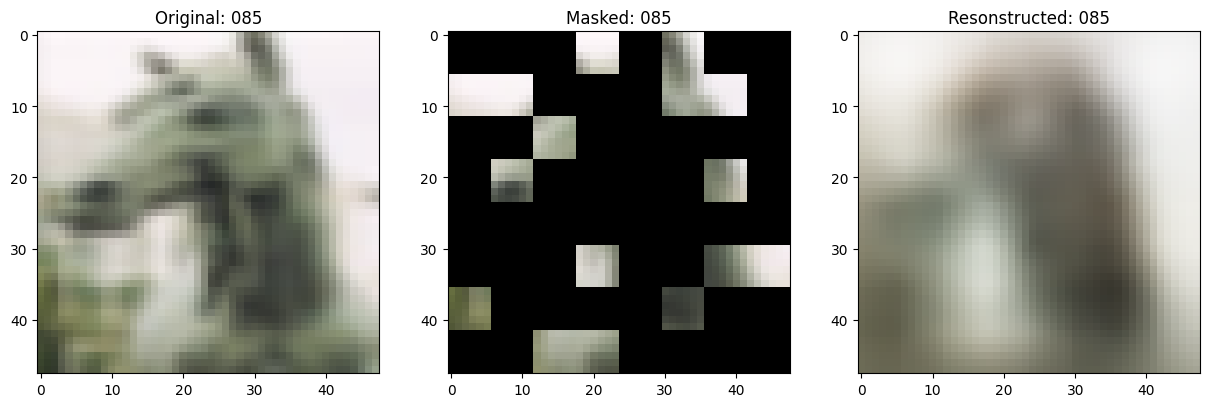

157/157 [==============================] - 21s 132ms/step - loss: 0.0149 - mae: 0.0861 - val_loss: 0.0150 - val_mae: 0.0859
Epoch 87/100
157/157 [==============================] - 20s 129ms/step - loss: 0.0149 - mae: 0.0859 - val_loss: 0.0150 - val_mae: 0.0858
Epoch 88/100
157/157 [==============================] - 20s 130ms/step - loss: 0.0149 - mae: 0.0860 - val_loss: 0.0150 - val_mae: 0.0856
Epoch 89/100
157/157 [==============================] - 20s 128ms/step - loss: 0.0149 - mae: 0.0858 - val_loss: 0.0150 - val_mae: 0.0857
Epoch 90/100
157/157 [==============================] - 20s 129ms/step - loss: 0.0149 - mae: 0.0859 - val_loss: 0.0149 - val_mae: 0.0854
Epoch 91/100
157/157 [==============================] - ETA: 0s - loss: 0.0148 - mae: 0.0857
Idx chosen: 247


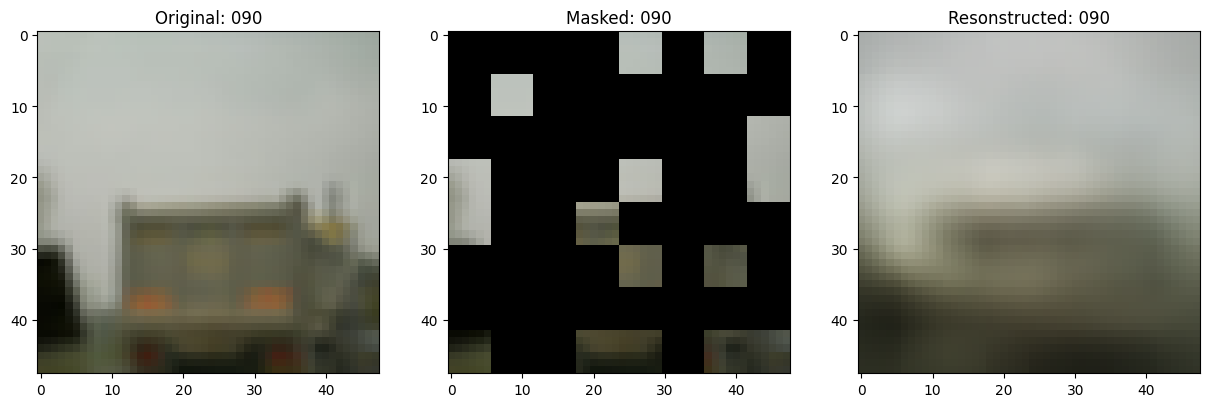

157/157 [==============================] - 21s 136ms/step - loss: 0.0148 - mae: 0.0857 - val_loss: 0.0150 - val_mae: 0.0857
Epoch 92/100
157/157 [==============================] - 20s 129ms/step - loss: 0.0148 - mae: 0.0857 - val_loss: 0.0149 - val_mae: 0.0854
Epoch 93/100
157/157 [==============================] - 21s 132ms/step - loss: 0.0149 - mae: 0.0858 - val_loss: 0.0149 - val_mae: 0.0855
Epoch 94/100
157/157 [==============================] - 20s 128ms/step - loss: 0.0148 - mae: 0.0857 - val_loss: 0.0150 - val_mae: 0.0856
Epoch 95/100
157/157 [==============================] - 21s 131ms/step - loss: 0.0148 - mae: 0.0857 - val_loss: 0.0150 - val_mae: 0.0858
Epoch 96/100
157/157 [==============================] - ETA: 0s - loss: 0.0149 - mae: 0.0859
Idx chosen: 36


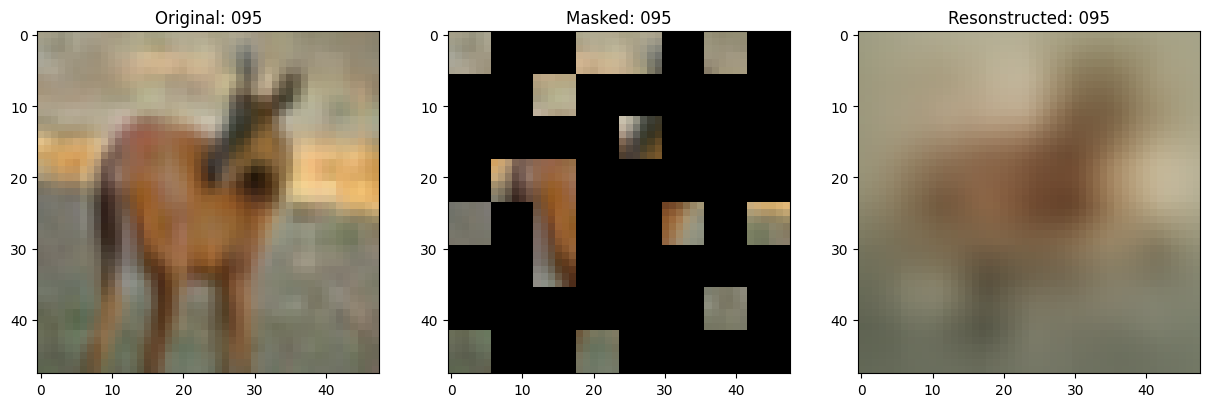

157/157 [==============================] - 21s 133ms/step - loss: 0.0149 - mae: 0.0859 - val_loss: 0.0150 - val_mae: 0.0860
Epoch 97/100
157/157 [==============================] - 20s 129ms/step - loss: 0.0149 - mae: 0.0860 - val_loss: 0.0150 - val_mae: 0.0860
Epoch 98/100
157/157 [==============================] - 21s 136ms/step - loss: 0.0149 - mae: 0.0863 - val_loss: 0.0151 - val_mae: 0.0863
Epoch 99/100
157/157 [==============================] - 20s 129ms/step - loss: 0.0150 - mae: 0.0867 - val_loss: 0.0152 - val_mae: 0.0870
Epoch 100/100
40/40 [==============================] - 2s 44ms/step - loss: 0.0155 - mae: 0.0887
Loss: 0.02
MAE: 0.09


In [17]:
optimizer = tfa.optimizers.AdamW(learning_rate=scheduled_lrs, weight_decay=WEIGHT_DECAY)

# Compile and pretrain the model.
mae_model.compile(
    optimizer=optimizer, loss=keras.losses.MeanSquaredError(), metrics=["mae"]
)
history = mae_model.fit(
    train_ds, epochs=EPOCHS, validation_data=val_ds, callbacks=train_callbacks,
)

# Measure its performance.
loss, mae = mae_model.evaluate(test_ds)
print(f"Loss: {loss:.2f}")
print(f"MAE: {mae:.2f}")

## Evaluation with linear probing



### Extract the encoder model along with other layers

In [18]:
# Extract the augmentation layers.
train_augmentation_model = mae_model.train_augmentation_model
test_augmentation_model = mae_model.test_augmentation_model

# Extract the patchers.
patch_layer = mae_model.patch_layer
patch_encoder = mae_model.patch_encoder
patch_encoder.downstream = True  # Swtich the downstream flag to True.

# Extract the encoder.
encoder = mae_model.encoder

# Pack as a model.
downstream_model = keras.Sequential(
    [
        layers.Input((IMAGE_SIZE, IMAGE_SIZE, 3)),
        patch_layer,
        patch_encoder,
        encoder,
        layers.BatchNormalization(),  # Refer to A.1 (Linear probing).
        layers.GlobalAveragePooling1D(),
        layers.Dense(NUM_CLASSES, activation="softmax"),
    ],
    name="linear_probe_model",
)

# Only the final classification layer of the `downstream_model` should be trainable.
for layer in downstream_model.layers[:-1]:
    layer.trainable = False

downstream_model.summary()

Model: "linear_probe_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 patches_1 (Patches)         (None, 64, 108)           0         
                                                                 
 patch_encoder_1 (PatchEnco  (None, 64, 128)           22252     
 der)                                                            
                                                                 
 mae_encoder (Functional)    (None, None, 128)         1981696   
                                                                 
 batch_normalization (Batch  (None, 64, 128)           512       
 Normalization)                                                  
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                

We are using average pooling to extract learned representations from the MAE encoder.
Another approach would be to use a learnable dummy token inside the encoder during
pretraining (resembling the [CLS] token). Then we can extract representations from that
token during the downstream tasks.



### Prepare datasets for linear probing

In [20]:
def prepare_data(images, labels, is_train=True):
    if is_train:
        augmentation_model = train_augmentation_model
    else:
        augmentation_model = test_augmentation_model

    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    if is_train:
        dataset = dataset.shuffle(BUFFER_SIZE)

    dataset = dataset.batch(BATCH_SIZE).map(
        lambda x, y: (augmentation_model(x), y), num_parallel_calls=AUTO
    )
    return dataset.prefetch(AUTO)


train_ds = prepare_data(x_train, y_train)
val_ds = prepare_data(x_train, y_train, is_train=False)
test_ds = prepare_data(x_test, y_test, is_train=False)

## Perform linear probing

In [ ]:
linear_probe_epochs = 50
linear_prob_lr = 0.1
warm_epoch_percentage = 0.1
steps = int((len(x_train) // BATCH_SIZE) * linear_probe_epochs)

warmup_steps = int(steps * warm_epoch_percentage)
scheduled_lrs = WarmUpCosine(
    learning_rate_base=linear_prob_lr,
    total_steps=steps,
    warmup_learning_rate=0.0,
    warmup_steps=warmup_steps,
)

optimizer = keras.optimizers.SGD(learning_rate=scheduled_lrs, momentum=0.9)
downstream_model.compile(
    optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
downstream_model.fit(train_ds, validation_data=val_ds, epochs=linear_probe_epochs)

loss, accuracy = downstream_model.evaluate(test_ds)
accuracy = round(accuracy * 100, 2)
print(f"Accuracy on the test set: {accuracy}%.")

Epoch 1/50
157/157 [==============================] - 40s 221ms/step - loss: 2.2304 - accuracy: 0.1778 - val_loss: 2.0138 - val_accuracy: 0.3038
Epoch 2/50
157/157 [==============================] - 34s 216ms/step - loss: 1.9004 - accuracy: 0.3490 - val_loss: 1.7848 - val_accuracy: 0.3861
Epoch 3/50
157/157 [==============================] - 34s 216ms/step - loss: 1.7603 - accuracy: 0.3907 - val_loss: 1.6926 - val_accuracy: 0.4112
Epoch 4/50
157/157 [==============================] - 34s 216ms/step - loss: 1.6924 - accuracy: 0.4090 - val_loss: 1.6450 - val_accuracy: 0.4243
Epoch 5/50
157/157 [==============================] - 24s 156ms/step - loss: 1.6543 - accuracy: 0.4181 - val_loss: 1.6138 - val_accuracy: 0.4317
Epoch 6/50
157/157 [==============================] - 34s 216ms/step - loss: 1.6265 - accuracy: 0.4250 - val_loss: 1.5908 - val_accuracy: 0.4367
Epoch 7/50
157/157 [==============================] - 24s 156ms/step - loss: 1.6084 - accuracy: 0.4293 - val_loss: 1.5733 - val_ac


We believe that with a more sophisticated hyperparameter tuning process and a longer
pretraining it is possible to improve this performance further. For comparison, we took
the encoder architecture and
[trained it from scratch](https://github.com/ariG23498/mae-scalable-vision-learners/blob/master/regular-classification.ipynb)
in a fully supervised manner. This gave us ~76% test top-1 accuracy. The authors of
MAE demonstrates strong performance on the ImageNet-1k dataset as well as
other downstream tasks like object detection and semantic segmentation.



## Final notes

We refer the interested readers to other examples on self-supervised learning present on
keras.io:

* [SimCLR](https://keras.io/examples/vision/semisupervised_simclr/)
* [NNCLR](https://keras.io/examples/vision/nnclr)
* [SimSiam](https://keras.io/examples/vision/simsiam)

This idea of using BERT flavored pretraining in computer vision was also explored in
[Selfie](https://arxiv.org/abs/1906.02940), but it could not demonstrate strong results.
Another concurrent work that explores the idea of masked image modeling is
[SimMIM](https://arxiv.org/abs/2111.09886). Finally, as a fun fact, we, the authors of
this example also explored the idea of ["reconstruction as a pretext task"](https://i.ibb.co/k5CpwDX/image.png)
in 2020 but we could not prevent the network from representation collapse, and
hence we did not get strong downstream performance.

We would like to thank [Xinlei Chen](http://xinleic.xyz/)
(one of the authors of MAE) for helpful discussions. We are grateful to
[JarvisLabs](https://jarvislabs.ai/) and
[Google Developers Experts](https://developers.google.com/programs/experts/)
program for helping with GPU credits.